In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
import clip
import json
import numpy as np
import torch
import torchtext
from PIL import Image
from IPython.display import Image as IM
from IPython.display import display
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-a79me82k
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-a79me82k
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=009cf29e0a79102cedf513b17c62ed00a099cbaac96c3f565ab82022bc116584
  Stored in directory: /tmp/pip-ephem-wheel-cache-hboj4wry/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 95.9MiB/s]


In [ ]:
display(IM(filename='/kaggle/input/vizwiz/data/Images/VizWiz_train_000000000001.jpg'))

In [2]:
data = None

with open('/kaggle/input/vizwiz/data/Annotations/train.json') as f:
  data = json.load(f)

In [3]:
with open('/kaggle/input/vizwiz/data/Annotations/val.json') as f:
  val_data = json.load(f)

In [4]:
answer_freq = {}
for entry in data:
    for ans in entry['answers']:
        if ans['answer'] in answer_freq.keys():
            answer_freq[ans['answer']]+=1
        else:
            answer_freq[ans['answer']] = 1

In [5]:
len(answer_freq.keys())

40271

In [6]:
def get_answers_from_dict(answers_dict):
    answers = [entry['answer'] for entry in answers_dict]
    return answers

In [7]:
def get_answer_clip(model, preprocess, img_path, answers):
    global device
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    text = clip.tokenize(answers).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    return np.argmax(probs)

In [8]:
def get_most_common(answers):
    global answer_frq
    idx = None
    freq = -1
    for i, answer in enumerate(answers):
        if answer in answer_freq.keys():
            fq = answer_freq[answer]
        else:
            fq = 0
        if fq>freq:
            idx = i
            freq = fq
    return idx

In [9]:
def get_answer_most_common(answers, model=None, preprocess=None, img_path=None, clip=False, freq=False):
    common_idx = None
    count = -1
    draws = []
    for idx,answer in enumerate(answers):
        c = answers.count(answer)
        if c > count:
            count = c
            common_idx = idx
            draws = [(answer, idx)]
        elif c==count:
            draws.append((answer, idx))
            
    if len(draws)>1:
        tmp = [a[0] for a in draws]
        if clip:
            common_idx = draws[get_answer_clip(model, preprocess, img_path, tmp)][1]
        elif freq:
            common_idx = draws[get_most_common(tmp)][1]
    return common_idx

In [ ]:
get_answer_clip(model, preprocess, '/kaggle/input/vizwiz/data/Images/VizWiz_train_000000000001.jpg', get_answers_from_dict(data[1]['answers']))

In [ ]:
get_answers_from_dict(data[1]['answers'])

In [10]:
def create_df(data, selection=2):
    df = []

    for i,entry in enumerate(data):
        if entry['answerable']==0:
            answer = 'unanswerable'
        else:
            if selection==1:
                idx = get_answer_clip(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+entry['image'], get_answers_from_dict(entry['answers']))
            elif selection==2:
                idx = get_answer_most_common(get_answers_from_dict(entry['answers']))
            elif selection==3:
                idx = get_answer_most_common(get_answers_from_dict(entry['answers']), model=model, preprocess=preprocess, img_path='/kaggle/input/vizwiz/data/Images/'+entry['image'], clip=True)
            elif selection==4:
                idx = get_answer_most_common(get_answers_from_dict(entry['answers']), freq=True)    
        
            answer = entry['answers'][idx]['answer']
            
        df.append([entry['image'], entry['answerable'], entry['question'], entry['answer_type'], answer])
        if i%1000==0:
            print('Checkpoint at: ' + str(i))

    return np.array(df)

In [11]:
selection = 4
df = create_df(data, selection)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000
Checkpoint at: 4000
Checkpoint at: 5000
Checkpoint at: 6000
Checkpoint at: 7000
Checkpoint at: 8000
Checkpoint at: 9000
Checkpoint at: 10000
Checkpoint at: 11000
Checkpoint at: 12000
Checkpoint at: 13000
Checkpoint at: 14000
Checkpoint at: 15000
Checkpoint at: 16000
Checkpoint at: 17000
Checkpoint at: 18000
Checkpoint at: 19000


In [12]:
with open('/kaggle/working/df'+str(selection)+'.npy', 'wb') as f:
    np.save(f,df)

In [20]:
with open('/kaggle/input/dfasdasd/df3.npy', 'rb') as f: 
    df = np.load(f)

In [13]:
df.shape

(20000, 5)

In [14]:
answers = np.array([entry[4] for entry in df])

In [15]:
answer_types = np.array([entry[3] for entry in df])

In [16]:
selection = 4
val_df = create_df(val_data, selection)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000


In [17]:
with open('/kaggle/working/val_df'+str(selection)+'.npy', 'wb') as f:
    np.save(f,val_df)

In [16]:
with open('/kaggle/input/dfasdasd/val_df.npy', 'rb') as f: 
    val_df = np.load(f)

In [18]:
val_answers = np.array([entry[4] for entry in val_df])

In [19]:
val_answer_types = np.array([entry[3] for entry in val_df])

In [20]:
def create_samples(model, preprocess, img_path, question, rotate=True):
    global device
    samples = []
    img = Image.open(img_path)
    
    encoded_q = model.encode_text(clip.tokenize(question).to(device))
    encoded_img = model.encode_image(preprocess(img).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))
    if not rotate:
        return torch.hstack([encoded_img, encoded_q])

    # Rotate Image By 90 Degree
    rotated_image1 = img.rotate(90)
    encoded_img_r90 = model.encode_image(preprocess(rotated_image1).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))

    # Rotate Image By 180 Degree
    rotated_image2 = img.rotate(-90)
    encoded_img_rn90 = model.encode_image(preprocess(rotated_image2).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))

#     # Rotate Image By 270 Degree
#     rotated_image3 = img.rotate(270)
#     encoded_img3 = model.encode_image(preprocess(rotated_image3).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))
        
    average = (encoded_img + encoded_img_r90 + encoded_img_rn90) / 3
    return torch.hstack([average, encoded_q])
        

In [23]:
def create_X(df, rotate=False):
    global device
    X = []

    with torch.no_grad():
      for i, entry in enumerate(df):
        X.extend(create_samples(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+entry[0], entry[2], rotate))
        if i%1000==0:
            print('Checkpoint at: ' + str(i))

    return torch.vstack(X)

In [24]:
X = create_X(df, rotate=True)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000
Checkpoint at: 4000
Checkpoint at: 5000
Checkpoint at: 6000
Checkpoint at: 7000
Checkpoint at: 8000
Checkpoint at: 9000
Checkpoint at: 10000
Checkpoint at: 11000
Checkpoint at: 12000
Checkpoint at: 13000
Checkpoint at: 14000
Checkpoint at: 15000
Checkpoint at: 16000
Checkpoint at: 17000
Checkpoint at: 18000
Checkpoint at: 19000


In [25]:
torch.save(X,'/kaggle/working/X.pt')

In [30]:
X = torch.load('/kaggle/input/dfasdasd/X.pt', map_location=device)

In [26]:
X_val = create_X(val_df)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000


In [27]:
torch.save(X_val,'/kaggle/working/X_val.pt')

In [31]:
X_val = torch.load('/kaggle/input/dfasdasd/X_val.pt')

In [28]:
lb_types = preprocessing.LabelBinarizer()

encoded_answer_types = lb_types.fit_transform(answer_types)

print(encoded_answer_types[10])

[0 1 0 0]


In [29]:
lb_types.classes_

array(['number', 'other', 'unanswerable', 'yes/no'], dtype='<U12')

In [30]:
lb_answers = preprocessing.LabelBinarizer()

encoded_answers = lb_answers.fit_transform(answers)

print(encoded_answers[10])

[0 0 0 ... 0 0 0]


In [31]:
lb_answers.classes_.shape

(4856,)

In [32]:
y = [(a_type, a) for a_type, a in zip(encoded_answer_types, encoded_answers)]

In [39]:
tmp_y = y
y = []
for t in tmp_y:
    for i in range(4):
        y.append(t)
        
# y= np.array(y)

In [33]:
val_encoded_answer_types = lb_types.transform(val_answer_types)
val_encoded_answers = lb_answers.transform(val_answers)
y_val = [(a_type, a) for a_type, a in zip(val_encoded_answer_types, val_encoded_answers)]

# This is a problem :)

In [41]:
c = 0
for ans in val_encoded_answers:
    c += ans.sum()
print(c)
print(len(val_encoded_answers))

2604
3173


In [42]:
c = 0
for ans in val_encoded_answer_types:
    c += ans.sum()
print(c)
print(len(val_encoded_answer_types))

3173
3173


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [34]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class VQADataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.atypes = []
        self.answers = []
        for atype, ans in labels:
          self.atypes.append(atype)
          self.answers.append(ans)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.Tensor(self.data[index])
        at, a = torch.Tensor(self.atypes[index]), torch.Tensor(self.answers[index])

        return x, at, a

In [35]:
train_set = DataLoader(VQADataset(X, y), batch_size=32)
# test_set = DataLoader(VQADataset(X_test, y_test), batch_size=512)
val_set = DataLoader(VQADataset(X_val, y_val), batch_size=32)

In [36]:
class VQA_Network(nn.Module):
    def __init__(self, num_classes, vocab_size, hidden_dim, embedding_dim):
        super(VQA_Network, self).__init__()

        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.fc2_answers = nn.Linear(hidden_dim, vocab_size)

        self.fc2_aux = nn.Linear(hidden_dim, num_classes)
        self.fc3_aux = nn.Linear(num_classes, vocab_size)

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.to(dtype=torch.float32)
        x = self.fc(x)
        x = self.norm(x)
        x = self.dropout(x)

        atype = self.fc2_aux(x)
        aux = self.fc3_aux(atype)

        answers = self.fc2_answers(x)

        answers = answers * self.sigmoid(aux)

        return answers, atype


In [37]:
num_classes = 4
vocab_size = 4856
hidden_dim = 512
embedding_dim = 1024

num_epochs = 200

# Instantiate the model
model = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss_a = 0.0
    running_loss_at = 0.0
    acc_a = 0
    acc_at = 0
    val_running_loss_a = 0.0
    val_running_loss_at = 0.0
    val_acc_a = 0
    val_acc_at = 0

    for xs, atypeset, answerset in train_set:
        # Move data to the device
        xs = xs.to(device)
        atypeset = atypeset.to(device)
        answerset = answerset.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        answers, atypes = model(xs)
        # print(xs.size())
        # print(labelset.size())
        # Compute loss
        answer_loss = criterion(answers, answerset)

        # Backward pass
        answer_loss.backward(retain_graph=True)

        # Compute loss
        atype_loss = criterion(atypes, atypeset)

        # Backward pass
        atype_loss.backward()

        # Update weights
        optimizer.step()

        # Update running loss
        running_loss_a += answer_loss.item()
        running_loss_at += atype_loss.item()
        acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
        acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

    acc_a = acc_a / len(y)
    acc_at = acc_at / len(y)
    # Calculate average loss for the epoch
    average_loss_a = running_loss_a / len(y)
    average_loss_at = running_loss_at / len(y)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss_a: {average_loss_a:.4f}, Loss_at: {average_loss_at:.4f}", end=' ')
    print(f"Acc_a: {acc_a:.4f}, Acc_at: {acc_at:.4f}", end='\t')
    
    with torch.no_grad():
        model.eval()
        for xs, atypeset, answerset in val_set:
            # Move data to the device
            xs = xs.to(device)
            atypeset = atypeset.to(device)
            answerset = answerset.to(device)

            # Forward pass
            answers, atypes = model(xs)
            # print(xs.size())
            # print(labelset.size())
            # Compute loss
            answer_loss = criterion(answers, answerset)

            # Compute loss
            atype_loss = criterion(atypes, atypeset)

            # Update running loss
            val_running_loss_a += answer_loss.item()
            val_running_loss_at += atype_loss.item()
            val_acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
            val_acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

        val_acc_a = val_acc_a / len(y_val)
        val_acc_at = val_acc_at / len(y_val)
        # Calculate average loss for the epoch
        val_average_loss_a = val_running_loss_a / len(y_val)
        val_average_loss_at = val_running_loss_at / len(y_val)

        # Print progress
        print(f"Validation: Loss_a: {val_average_loss_a:.4f}, Loss_at: {val_average_loss_at:.4f}", end=' ')
        print(f"Acc_a: {val_acc_a:.4f}, Acc_at: {val_acc_at:.4f}")


# Training complete


Epoch [1/200], Loss_a: 0.1743, Loss_at: 0.0234 Acc_a: 0.3467, Acc_at: 0.7034	Validation: Loss_a: 0.1022, Loss_at: 0.0196 Acc_a: 0.3735, Acc_at: 0.7655
Epoch [2/200], Loss_a: 0.1534, Loss_at: 0.0204 Acc_a: 0.3691, Acc_at: 0.7392	Validation: Loss_a: 0.0955, Loss_at: 0.0187 Acc_a: 0.3914, Acc_at: 0.7684
Epoch [3/200], Loss_a: 0.1425, Loss_at: 0.0195 Acc_a: 0.3836, Acc_at: 0.7532	Validation: Loss_a: 0.0914, Loss_at: 0.0185 Acc_a: 0.3965, Acc_at: 0.7734
Epoch [4/200], Loss_a: 0.1329, Loss_at: 0.0187 Acc_a: 0.4022, Acc_at: 0.7587	Validation: Loss_a: 0.0869, Loss_at: 0.0183 Acc_a: 0.4084, Acc_at: 0.7680
Epoch [5/200], Loss_a: 0.1251, Loss_at: 0.0182 Acc_a: 0.4146, Acc_at: 0.7623	Validation: Loss_a: 0.0830, Loss_at: 0.0178 Acc_a: 0.4163, Acc_at: 0.7677
Epoch [6/200], Loss_a: 0.1179, Loss_at: 0.0179 Acc_a: 0.4285, Acc_at: 0.7667	Validation: Loss_a: 0.0794, Loss_at: 0.0175 Acc_a: 0.4270, Acc_at: 0.7690
Epoch [7/200], Loss_a: 0.1112, Loss_at: 0.0175 Acc_a: 0.4455, Acc_at: 0.7680	Validation: Loss_

In [ ]:
lb_types.classes_

In [39]:
idx = 700

answer, atype = model(X_val[idx])
print(lb_answers.classes_[torch.argmax(answer)])
print(lb_types.classes_[torch.argmax(atype)])
print('-------------------')
print(val_df[idx])

black
unanswerable
-------------------
['VizWiz_val_000000028700.jpg' '1' 'Color is this shirt?' 'other' 'brown']


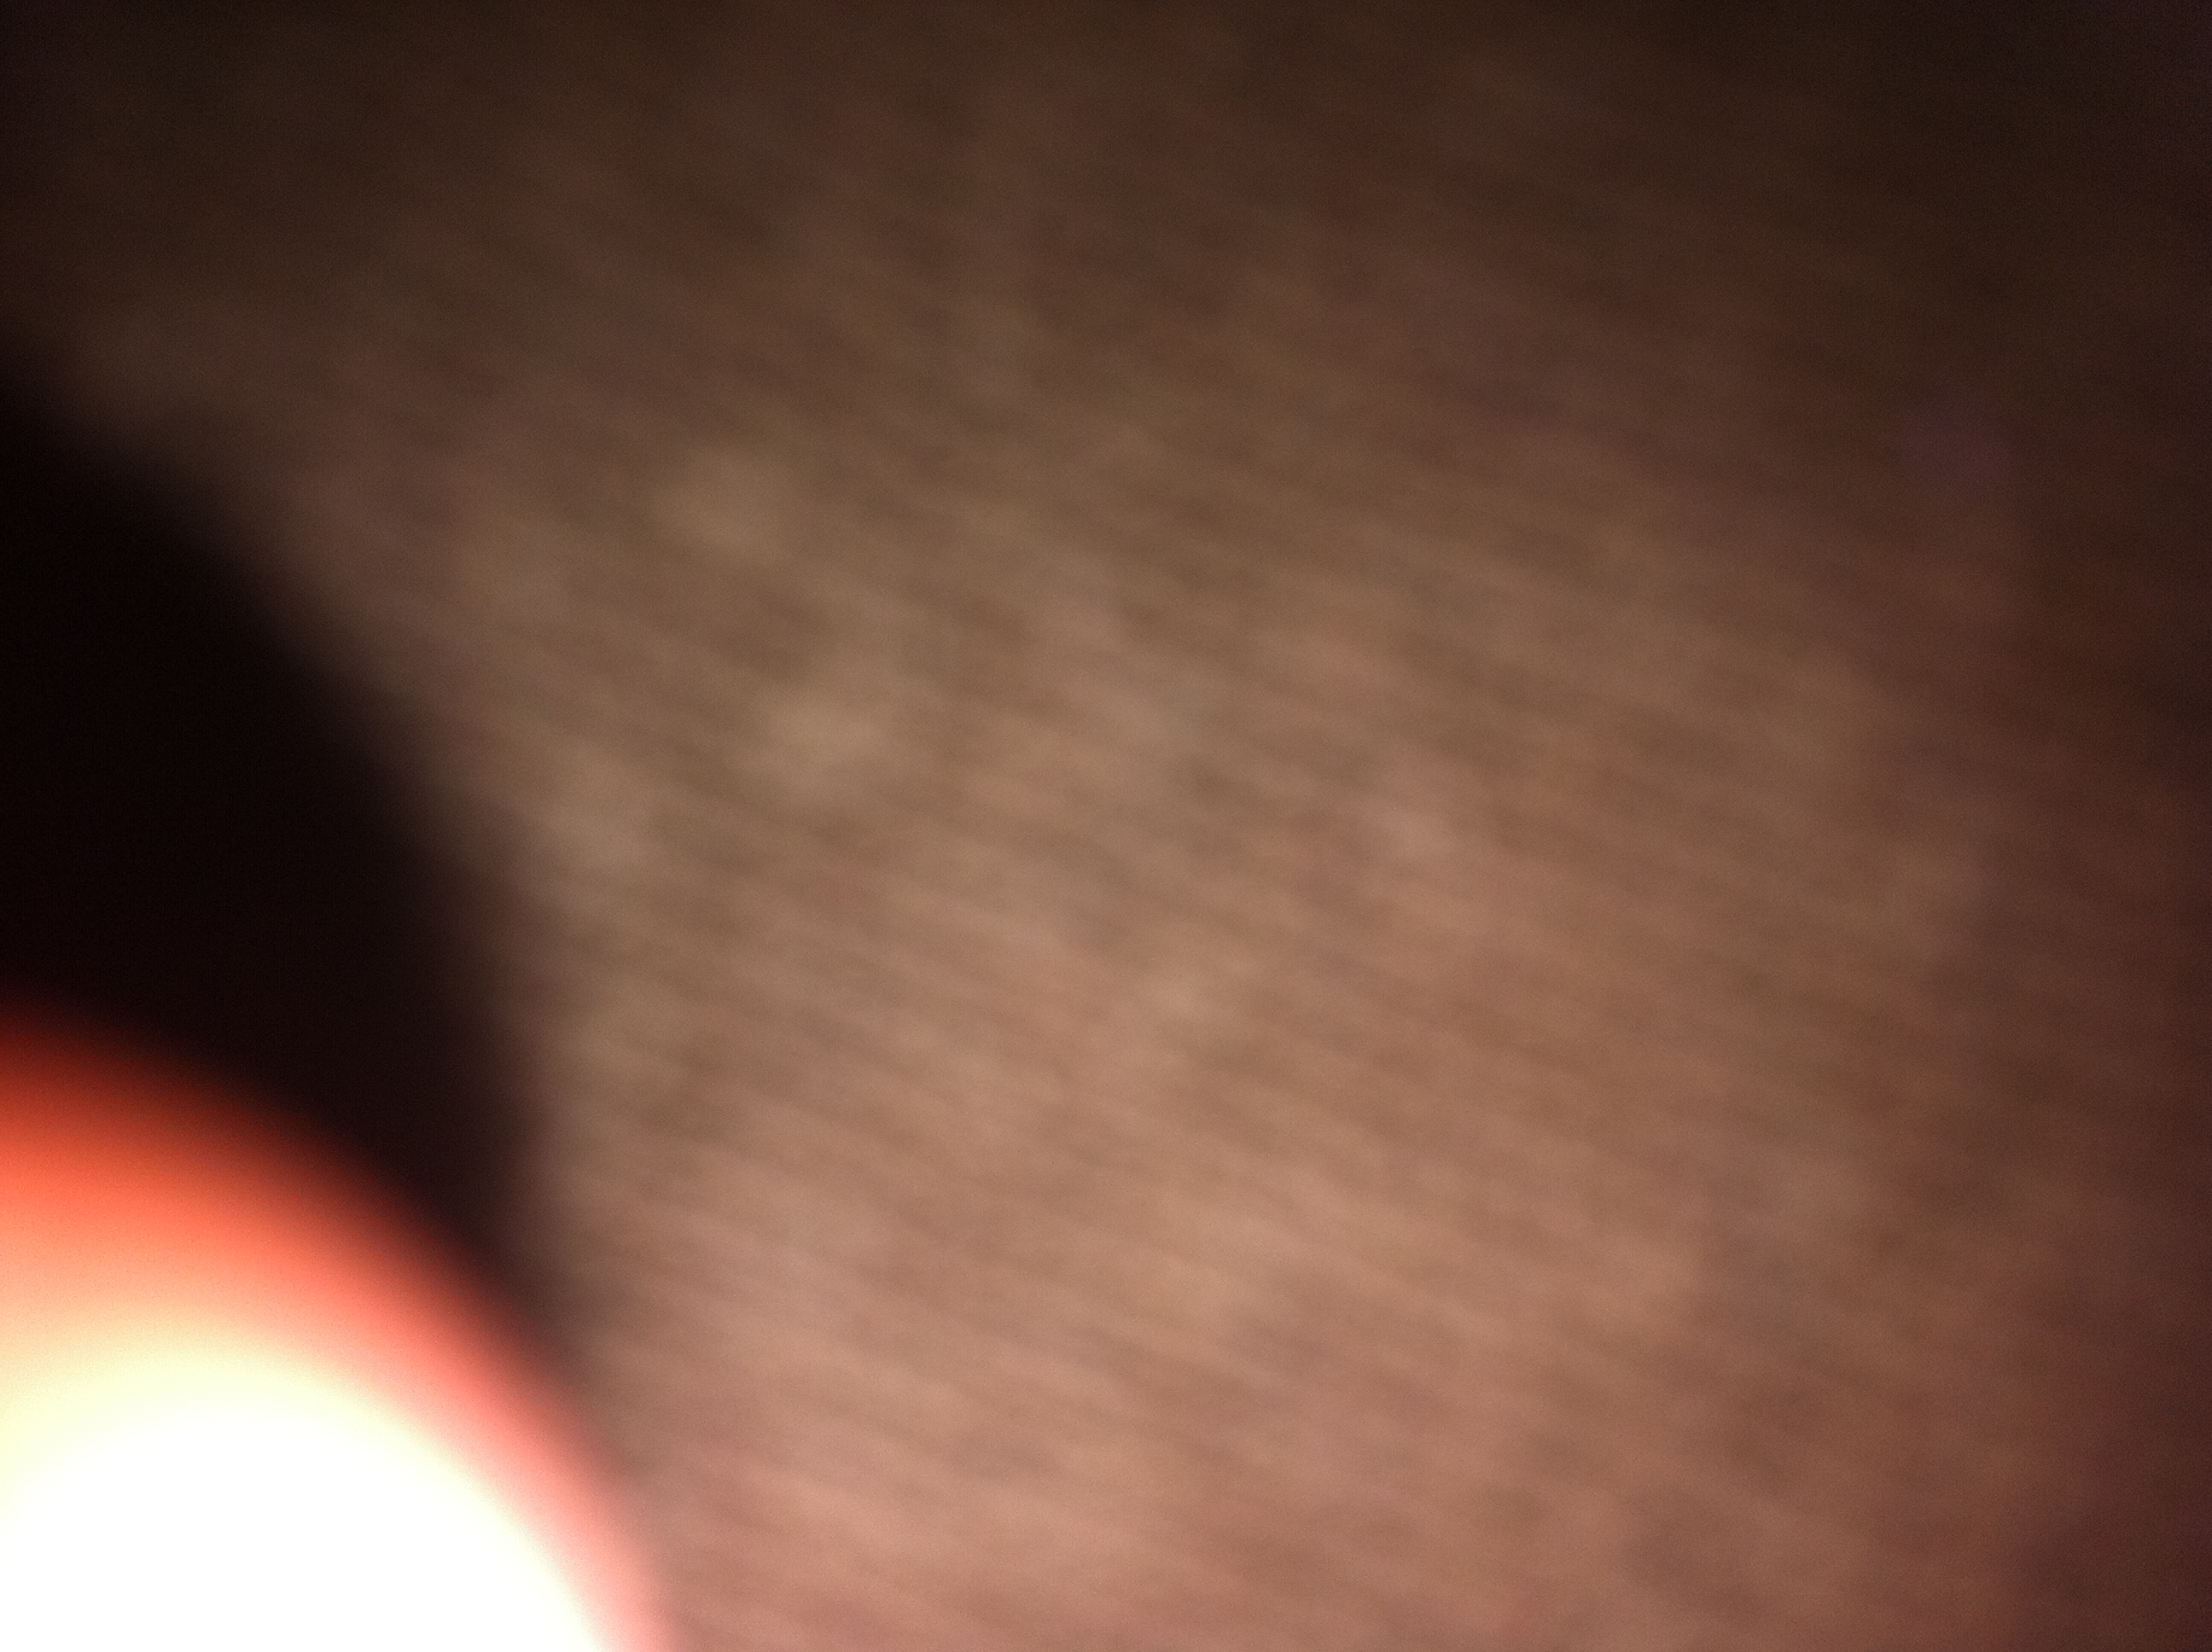

In [63]:
display(IM(filename='/kaggle/input/vizwiz/data/Images/'+val_df[idx][0]))

In [56]:
with open('/kaggle/working/classes.txt', 'w') as f:
    for c in lb_answers.classes_:
        f.write(c)
        f.write('\n')